## Exploring US Education Data
In this assessment, you'll continue working with the [U.S. Education dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project) from Kaggle. The data gives detailed, state-level information on the several facets of the state of education on an annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You can access the data from the Thinkful database.

The dataset contains data spanning 26 years of US education.

We will start by importing relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine, text
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

Next, we will define two helper functions.

In [8]:
# Pass in a dataframe, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

In [9]:
def plot_naep(df,ranges,description):
    fig_hist = plt.figure(figsize=(15,15))
    fig_hist.suptitle('Average NAEP test scores, Minnesota: {}'.format(description),fontsize=14)
    plt.subplot(2,2,1)
    math4_hist = plt.hist(df['AVG_MATH_4_SCORE'],range=ranges[0])
    plt.title('4th grade Math')
    plt.subplot(2,2,2)
    math8 = plt.hist(df['AVG_MATH_8_SCORE'],range=ranges[1])
    plt.title('8th grade Math')
    plt.subplot(2,2,3)
    reading4 = plt.hist(df['AVG_READING_4_SCORE'],range=ranges[2])
    plt.title('4th grade Reading')
    plt.subplot(2,2,4)
    reading8 = plt.hist(df['AVG_READING_8_SCORE'],range=ranges[3])
    plt.title('8th grade Reading')
    plt.show()

Then, we will connect to the US Education database.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# education_df = pd.read_sql_query('select * from useducation',con=engine)
with engine.begin() as conn:
    query = text("""SELECT * FROM useducation""")
    education_df = pd.read_sql_query(query, conn)


# No need for an open connection,
# because you're only doing a single query
engine.dispose()


We will analyze the data and clean up records with missing or null values.

In [3]:
# Handle missing values - 'STATE' has values less than 26 rows/year.
state_counts = education_df['STATE'].value_counts()

# We will remove the records that have less than 26 states
education_df.groupby('STATE').filter(lambda x : len(x)<=26)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,2017_VERMONT,VERMONT,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.893297,287.623388,226.445343,268.752420
1488,2017_WASHINGTON,WASHINGTON,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,241.701001,289.131257,223.123409,267.744778
1489,2017_WEST_VIRGINIA,WEST_VIRGINIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,236.057019,273.415854,217.316396,271.617023
1490,2017_WISCONSIN,WISCONSIN,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.389213,288.143144,219.612694,258.700304


In [6]:
# As suggested in the data cleaning exercise, interpolate missing values

education_df = interpolate_missing(education_df,
                                     'STATE',
                                     ['ENROLL',
                                      'OTHER_EXPENDITURE',
                                      'GRADES_PK_G',
                                      'GRADES_KG_G',
                                      'GRADES_4_G',
                                      'GRADES_8_G',
                                      'GRADES_12_G',
                                      'GRADES_1_8_G',
                                      'GRADES_9_12_G',
                                      'GRADES_ALL_G'
                                     ],
                                     'both')

##### Q1. Derive the descriptive statistics of the data and discuss the points you find remarkable.

In [7]:
education_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492.000000,1.331000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.331000e+03,...,1488.000000,1488.000000,1488.000000,1.488000e+03,1.488000e+03,1.451000e+03,536.000000,532.000000,533.000000,498.000000
mean,2004.433646,9.131361e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.282389e+05,...,64095.298387,63761.236895,54272.839382,5.152247e+05,2.458877e+05,7.977533e+05,234.768293,278.414711,218.866154,263.661132
std,7.393983,1.062873e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.366432e+05,...,80468.744828,79004.690975,68752.714991,6.439541e+05,3.091385e+05,9.807442e+05,10.221511,10.159722,7.769616,6.803725
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,633.000000,437.000000,311.000000,4.878000e+03,1.808000e+03,7.254000e+03,187.134670,232.831510,178.557612,236.379102
25%,1998.000000,2.560480e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,1.010325e+05,...,13235.500000,12973.000000,10736.000000,1.063222e+05,4.976450e+04,1.711815e+05,229.694352,272.761598,214.663401,259.533171
50%,2004.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.689240e+05,...,42738.000000,42993.500000,36429.500000,3.422030e+05,1.612745e+05,5.370150e+05,237.238552,280.618803,220.416034,265.010912
75%,2011.000000,1.006874e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.165750e+05,...,75307.750000,76261.250000,67656.750000,6.099108e+05,2.912305e+05,9.268625e+05,241.995486,285.347428,223.999337,268.190121
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,280.499130


The descriptive statistics show that the total revenue has a mean of $9,092,082$ while total expenditure has a mean of $9,196,681$. As we calculated budget deficit as total revenue - total expenditure, it is clear that some states are losing money and are not properly funding K12 education.

Our first observation is that the District of Columbia receives no state revenue. This is because it is not a state and therefore receives local revenue.

In [10]:
education_df.loc[education_df['STATE_REVENUE'] == 0]


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
8,1992_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1992,80937.0,709480.0,64749.0,0.0,644731.0,742893.0,329160.0,...,5832.0,5000.0,3433.0,47009.0,18173.0,70000.0,192.600553,234.924621,178.557612,265.976765
60,1993_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1993,80937.0,721151.0,73882.0,0.0,647269.0,719440.0,339266.0,...,5870.0,4935.0,3303.0,46917.0,17854.0,69987.0,NaN,NaN,NaN,NaN
113,1994_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1994,80678.0,735720.0,79432.0,0.0,656288.0,769818.0,351028.0,...,5783.0,5031.0,3203.0,46557.0,16950.0,69015.0,NaN,NaN,NaN,NaN
165,1995_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1995,80450.0,700111.0,65527.0,0.0,634584.0,708224.0,336543.0,...,5852.0,4749.0,2972.0,46492.0,16727.0,68606.0,NaN,NaN,NaN,NaN
217,1996_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1996,79802.0,678874.0,57870.0,0.0,621004.0,703245.0,334893.0,...,5442.0,4625.0,3042.0,46313.0,16241.0,67598.0,187.134670,232.831510,181.626990,264.938466
268,1997_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1997,78648.0,711625.0,73177.0,0.0,638448.0,686059.0,337401.0,...,5357.0,4376.0,2961.0,45470.0,15896.0,66522.0,NaN,NaN,NaN,NaN
320,1998_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1998,77111.0,706938.0,116366.0,0.0,590572.0,716740.0,283484.0,...,5607.0,4083.0,2572.0,42997.0,13932.0,61760.0,NaN,NaN,NaN,NaN
371,1999_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1999,71889.0,758072.0,122970.0,0.0,635102.0,738942.0,314138.0,...,6070.0,4408.0,2897.0,45931.0,15849.0,66554.0,NaN,NaN,NaN,NaN
424,2000_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2000,70762.0,881423.0,184825.0,0.0,696598.0,858807.0,318260.0,...,5830.0,3371.0,2785.0,41330.0,13781.0,59400.0,193.289774,234.428798,190.518073,252.501705
476,2001_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2001,68925.0,1042261.0,114876.0,0.0,927385.0,1026146.0,412276.0,...,5561.0,3662.0,2815.0,41292.0,13530.0,58927.0,NaN,NaN,NaN,NaN


A second observation is that Wyoming did not have students in the Pre-Kindergarden programs until 2000. Wyoming is also missing average math and reading scores for a fair amount of years in the 1990s.

In [16]:
education_df.loc[education_df['GRADES_PK_G'] == 0].sort_values(['STATE','YEAR'])

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
51,1992_WYOMING,WYOMING,1992,95012.0,629748.0,31714.0,314216.0,283818.0,624941.0,339953.0,...,8049.0,8078.0,6613.0,64614.0,28515.0,88832.0,225.377592,275.080076,221.185556,NaN
103,1993_WYOMING,WYOMING,1993,100313.0,615130.0,35437.0,308683.0,271010.0,614807.0,334071.0,...,8046.0,8268.0,6548.0,64212.0,29497.0,88832.0,NaN,NaN,NaN,NaN
156,1994_WYOMING,WYOMING,1994,100899.0,674921.0,38849.0,351472.0,284600.0,623146.0,344562.0,...,7982.0,8203.0,6642.0,63201.0,30184.0,88832.0,NaN,NaN,NaN,NaN
208,1995_WYOMING,WYOMING,1995,100314.0,634237.0,42456.0,303913.0,287868.0,642935.0,357039.0,...,7577.0,8302.0,6679.0,61796.0,30928.0,88832.0,NaN,NaN,NaN,NaN
259,1996_WYOMING,WYOMING,1996,99859.0,664057.0,41007.0,339629.0,283421.0,676305.0,360100.0,...,7283.0,8270.0,7129.0,60539.0,31722.0,88832.0,223.196003,274.778947,219.010780,254.523637
311,1997_WYOMING,WYOMING,1997,98777.0,660079.0,43171.0,320566.0,296342.0,695127.0,362705.0,...,7061.0,8232.0,7077.0,58894.0,31388.0,88832.0,NaN,NaN,NaN,NaN
362,1998_WYOMING,WYOMING,1998,96504.0,703280.0,47201.0,330204.0,325875.0,706801.0,366104.0,...,6873.0,7942.0,7057.0,57540.0,31292.0,88832.0,NaN,NaN,NaN,NaN
415,1999_WYOMING,WYOMING,1999,94420.0,780875.0,57983.0,408271.0,314621.0,739019.0,390565.0,...,6878.0,7715.0,7049.0,55493.0,30436.0,85929.0,NaN,NaN,NaN,NaN
36,2001_WYOMING,WYOMING,2001,89711.0,804297.0,69172.0,403021.0,332104.0,787949.0,426072.0,...,6587.0,7211.0,6855.0,53091.0,29035.0,88832.0,NaN,NaN,NaN,NaN


#### Q2. Choose a state (such as California) and draw a line graph of its total revenues and total expenditures over the years. How do these two variables evolve during these years? Try to explain the peaks and troughs with some state-wise news and information around those dates.

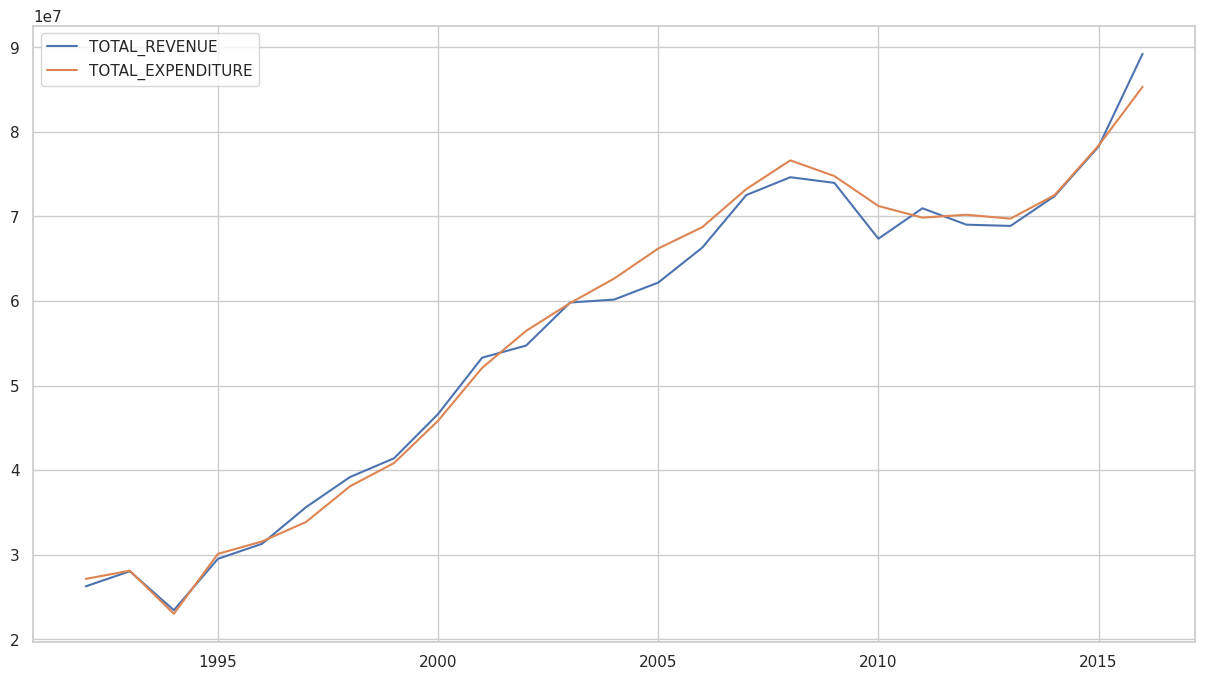

In [20]:
plt.figure(figsize=(15,8))
education_info = education_df.loc[education_df['STATE'] == 'CALIFORNIA'][['YEAR','TOTAL_REVENUE','TOTAL_EXPENDITURE']]
plt.plot(education_info['YEAR'],education_info[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])
plt.legend(education_info[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])

The decrease between 1992 and 1994 is explained by [budget issues](https://lao.ca.gov/analysis_1993/06_k-12_1993.pdf). The later decrease near 2010 is due to a [fiscal crisis](https://www.air.org/sites/default/files/downloads/report/CA_Fiscal_Crisis_Report_Draft_Final_May_19_0.pdf) starting around 2008.

#### Q3. In your chosen state, in which of the lessons are the students more successful—math or reading?

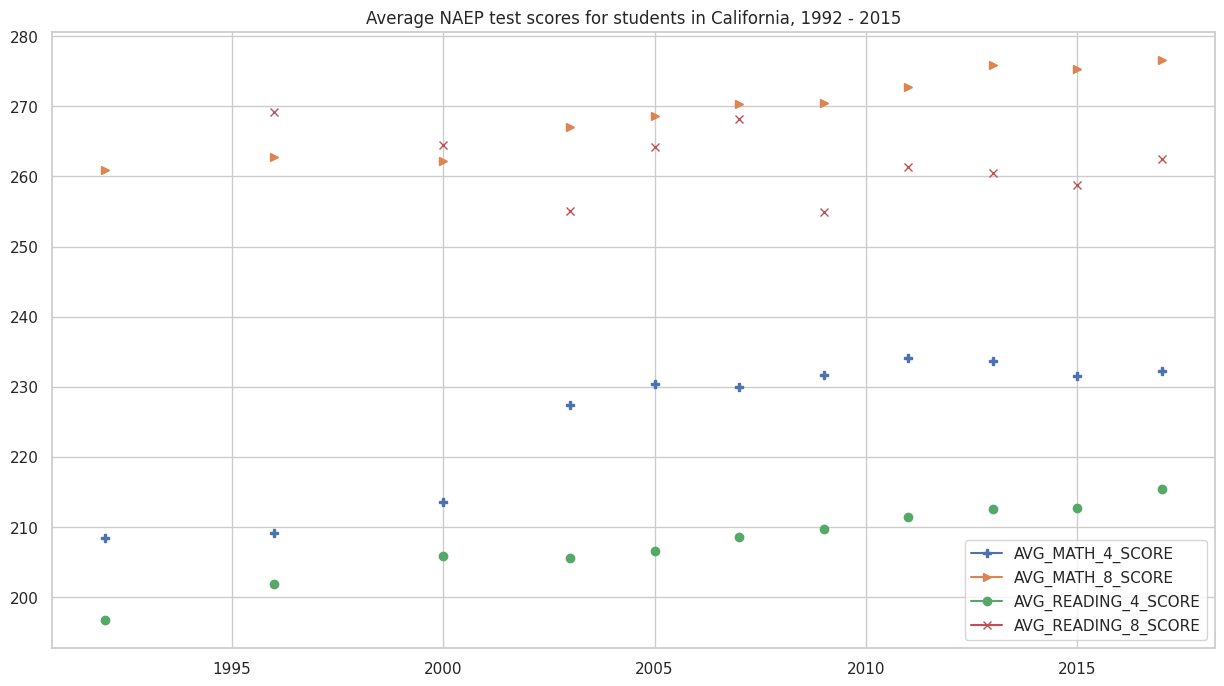

In [24]:
fig = plt.figure(figsize=(15,8))

education_info = education_df.loc[education_df['STATE'] == 'CALIFORNIA'][['STATE','YEAR',
                                                        'AVG_MATH_4_SCORE',
                                                        'AVG_MATH_8_SCORE',
                                                        'AVG_READING_4_SCORE',
                                                        'AVG_READING_8_SCORE'
                                                       ]]
math4 = plt.plot(education_info['YEAR'],education_info[['AVG_MATH_4_SCORE']],marker='P')
math8 = plt.plot(education_info['YEAR'],education_info[['AVG_MATH_8_SCORE']],marker='>')
reading4 = plt.plot(education_info['YEAR'],education_info[['AVG_READING_4_SCORE']],marker='o')
reading8 = plt.plot(education_info['YEAR'],education_info[['AVG_READING_8_SCORE']],marker='x')

legend = plt.legend(education_info[['AVG_MATH_4_SCORE',
                    'AVG_MATH_8_SCORE',
                    'AVG_READING_4_SCORE',
                    'AVG_READING_8_SCORE'
                     ]])

title = plt.title('Average NAEP test scores for students in California, 1992 - 2015')

According to these results, eight graders score better in math and science than fourth graders.

#### Q4. What are the distributions of the math and reading scores in the sample?

In [25]:
education_info.describe()

,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,26.000000,11.000000,11.000000,11.000000,10.000000
mean,2004.500000,225.659625,269.355244,207.911547,261.902652
std,7.648529,10.063398,5.638743,5.363399,4.861743
min,1992.000000,208.398961,260.892247,196.764414,254.895247
25%,1998.250000,220.510053,264.910990,205.774512,259.188273
50%,2004.500000,230.366957,270.381784,208.522186,261.902941
75%,2010.750000,231.968934,274.047188,211.952302,264.416677
max,2017.000000,234.164993,276.638200,215.421814,269.197451


We will use the minimum and maximum of each variable to set the ranges of their respective histograms and visualize the distribution of every average score.

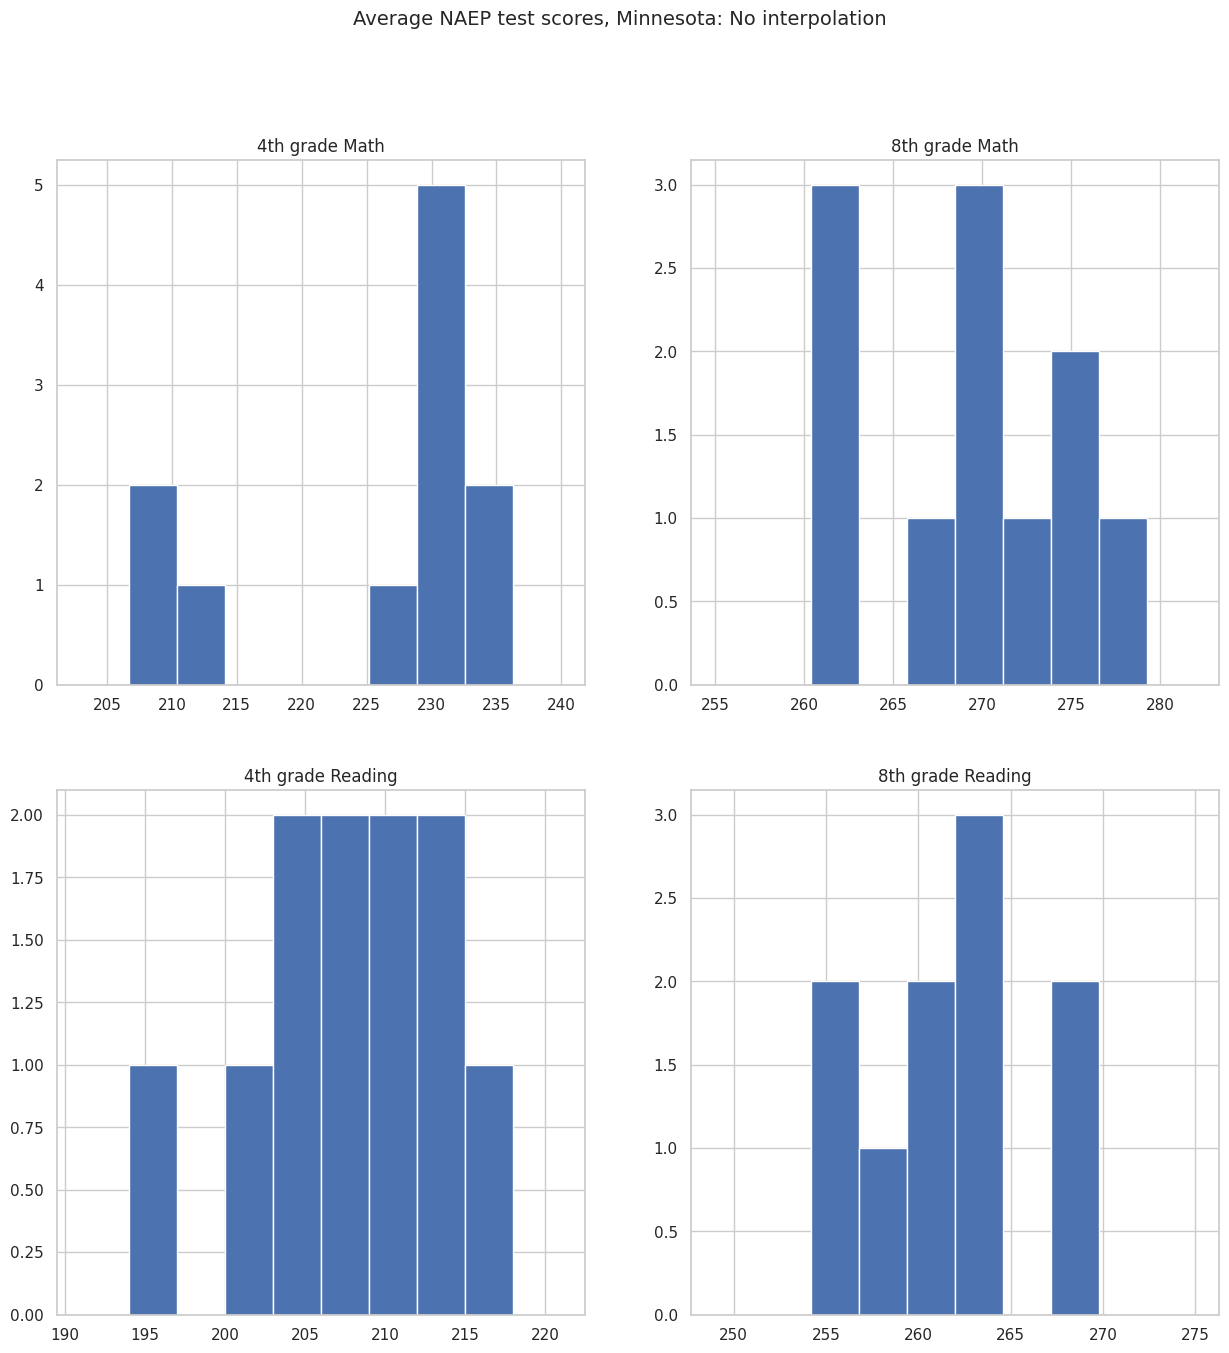

In [28]:
test_ranges = [(203,240),(255,282),(191,221),(249,275)]
plot_naep(education_info,test_ranges,"No interpolation")

It is difficult to identify what is normally distributed or right/left skewed given the amount of sample data.

Through the analysis below, we can see that this is due to missing values.

In [30]:
education_df_mean = education_info
education_info

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
4,CALIFORNIA,1992,208.398961,260.892247,196.764414,NaN
56,CALIFORNIA,1993,NaN,NaN,NaN,NaN
108,CALIFORNIA,1994,NaN,NaN,NaN,NaN
161,CALIFORNIA,1995,NaN,NaN,NaN,NaN
213,CALIFORNIA,1996,209.129083,262.772478,201.912591,269.197451
264,CALIFORNIA,1997,NaN,NaN,NaN,NaN
316,CALIFORNIA,1998,NaN,NaN,NaN,NaN
367,CALIFORNIA,1999,NaN,NaN,NaN,NaN
420,CALIFORNIA,2000,213.565125,262.171027,205.916588,264.494066
472,CALIFORNIA,2001,NaN,NaN,NaN,NaN


#### Q5. Notice there are too many missing values for math and reading scores. Fill out the missing values using mean, median, and linear interpolation. Then compare the effects of these techniques on the distributions of the score variables.

Strategy 1: Using `mean()` to fill in the missing values.

In [36]:
education_df_mean = education_info.fillna(education_info.mean())
education_df_mean

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
4,CALIFORNIA,1992,208.398961,260.892247,196.764414,261.902652
56,CALIFORNIA,1993,225.659625,269.355244,207.911547,261.902652
108,CALIFORNIA,1994,225.659625,269.355244,207.911547,261.902652
161,CALIFORNIA,1995,225.659625,269.355244,207.911547,261.902652
213,CALIFORNIA,1996,209.129083,262.772478,201.912591,269.197451
264,CALIFORNIA,1997,225.659625,269.355244,207.911547,261.902652
316,CALIFORNIA,1998,225.659625,269.355244,207.911547,261.902652
367,CALIFORNIA,1999,225.659625,269.355244,207.911547,261.902652
420,CALIFORNIA,2000,213.565125,262.171027,205.916588,264.494066
472,CALIFORNIA,2001,225.659625,269.355244,207.911547,261.902652


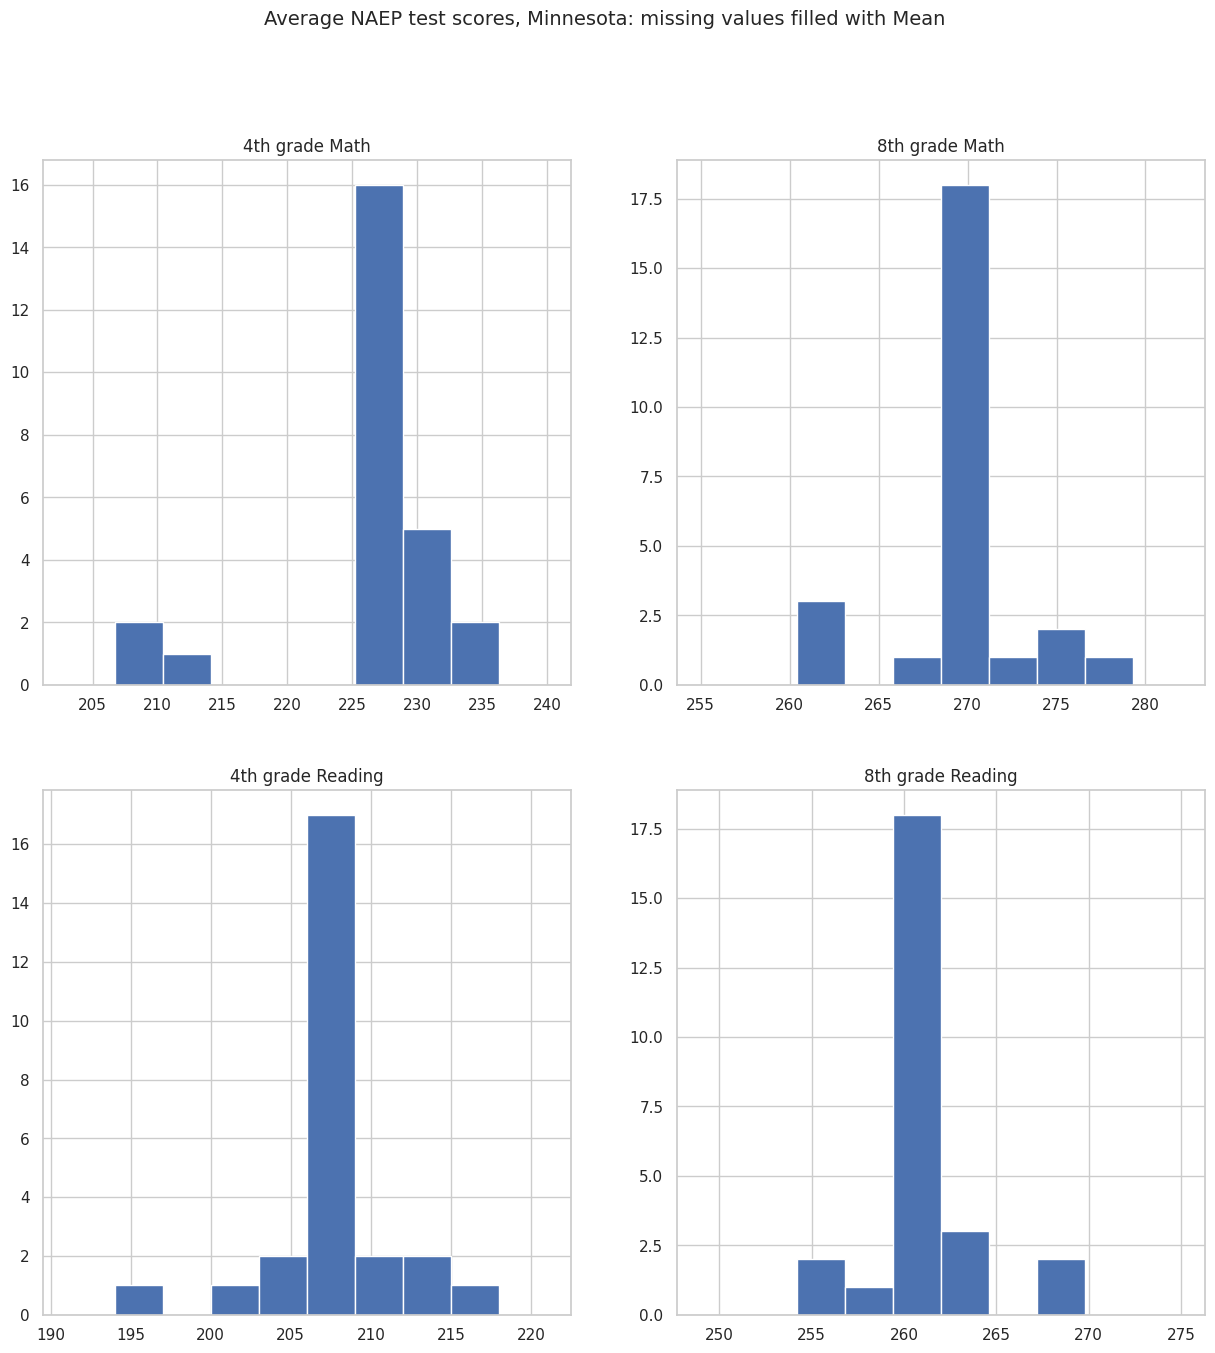

In [40]:
plot_naep(education_df_mean,test_ranges,"missing values filled with Mean")

This looks harmful as it makes most of the data approach the mean.

Strategy 2: Using `median()` to fill in the missing values.

In [37]:
education_df_median = education_info.fillna(education_info.median())
education_df_median

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
4,CALIFORNIA,1992,208.398961,260.892247,196.764414,261.902941
56,CALIFORNIA,1993,230.366957,270.381784,208.522186,261.902941
108,CALIFORNIA,1994,230.366957,270.381784,208.522186,261.902941
161,CALIFORNIA,1995,230.366957,270.381784,208.522186,261.902941
213,CALIFORNIA,1996,209.129083,262.772478,201.912591,269.197451
264,CALIFORNIA,1997,230.366957,270.381784,208.522186,261.902941
316,CALIFORNIA,1998,230.366957,270.381784,208.522186,261.902941
367,CALIFORNIA,1999,230.366957,270.381784,208.522186,261.902941
420,CALIFORNIA,2000,213.565125,262.171027,205.916588,264.494066
472,CALIFORNIA,2001,230.366957,270.381784,208.522186,261.902941


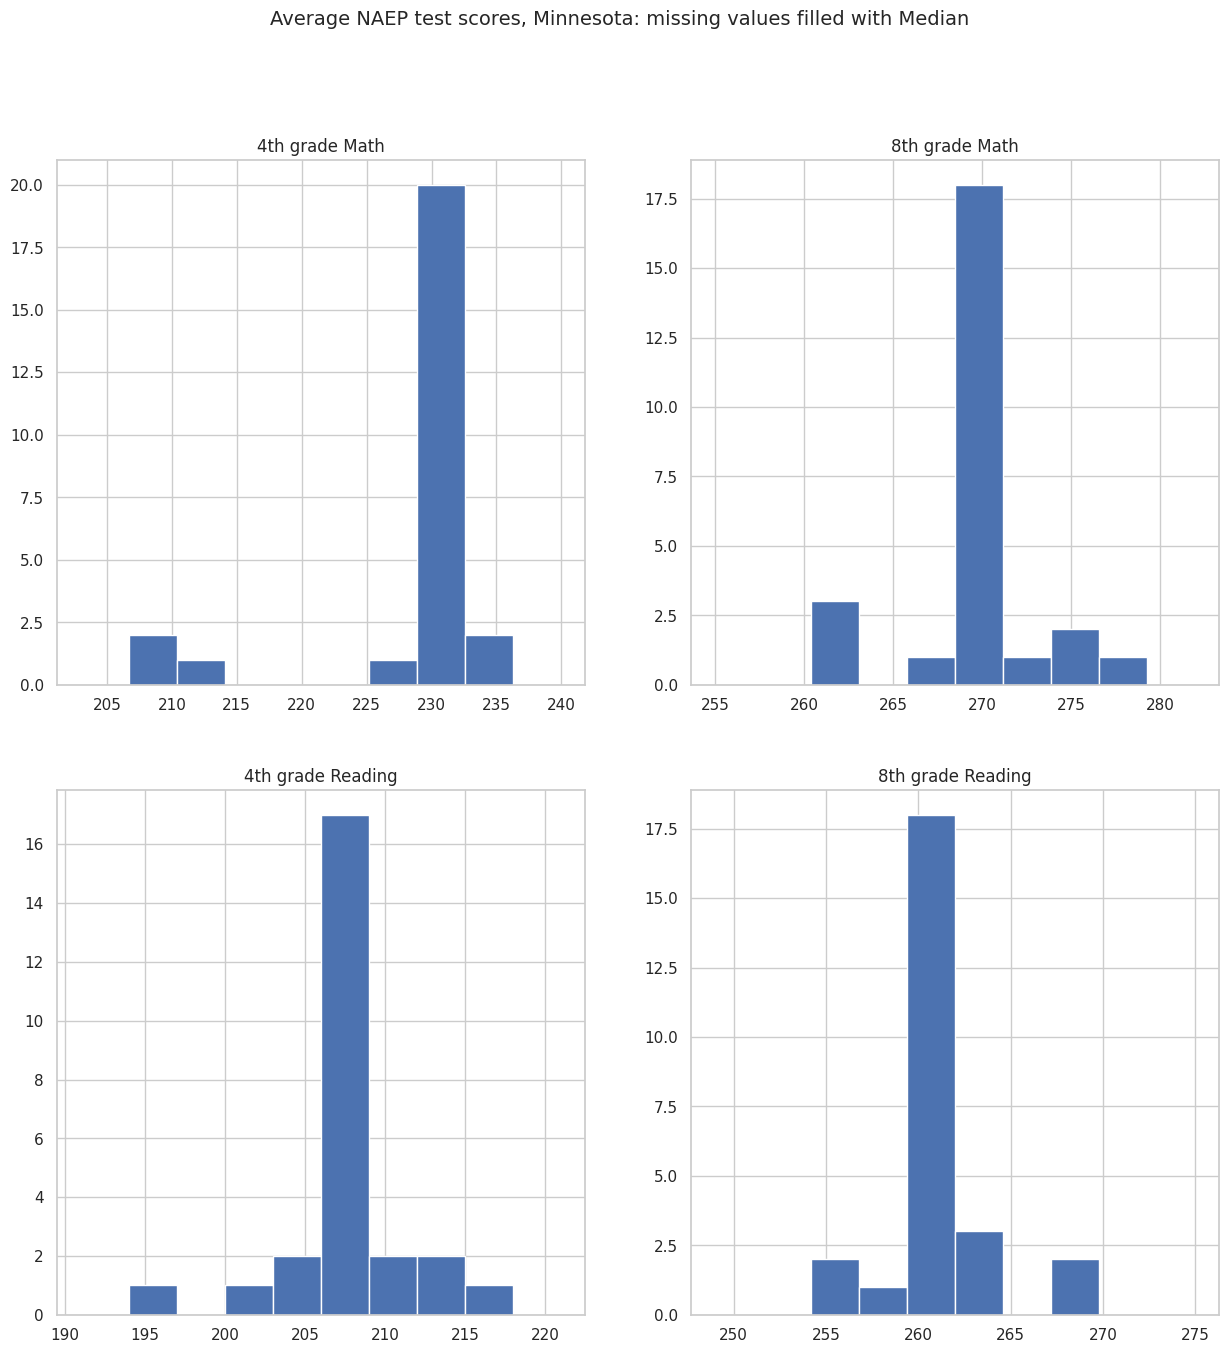

In [45]:
plot_naep(education_df_median,test_ranges,"missing values filled with Median")

These plots look similar to those genrated by the mean.

Strategy 3: Interpolating the missing values.

In [44]:
education_df_interp = interpolate_missing(education_info,
                                     'STATE',
                                     ['AVG_MATH_4_SCORE',
                                      'AVG_MATH_8_SCORE',
                                      'AVG_READING_4_SCORE',
                                      'AVG_READING_8_SCORE'
                                     ],
                                     'both',interp_how='linear')
education_df_interp

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
4,CALIFORNIA,1992,208.398961,260.892247,196.764414,269.197451
56,CALIFORNIA,1993,208.581491,261.362305,198.051458,269.197451
108,CALIFORNIA,1994,208.764022,261.832363,199.338502,269.197451
161,CALIFORNIA,1995,208.946552,262.302421,200.625547,269.197451
213,CALIFORNIA,1996,209.129083,262.772478,201.912591,269.197451
264,CALIFORNIA,1997,210.238093,262.622115,202.913590,268.021605
316,CALIFORNIA,1998,211.347104,262.471753,203.914589,266.845758
367,CALIFORNIA,1999,212.456114,262.321390,204.915588,265.669912
420,CALIFORNIA,2000,213.565125,262.171027,205.916588,264.494066
472,CALIFORNIA,2001,218.195077,263.797185,205.821871,261.353837


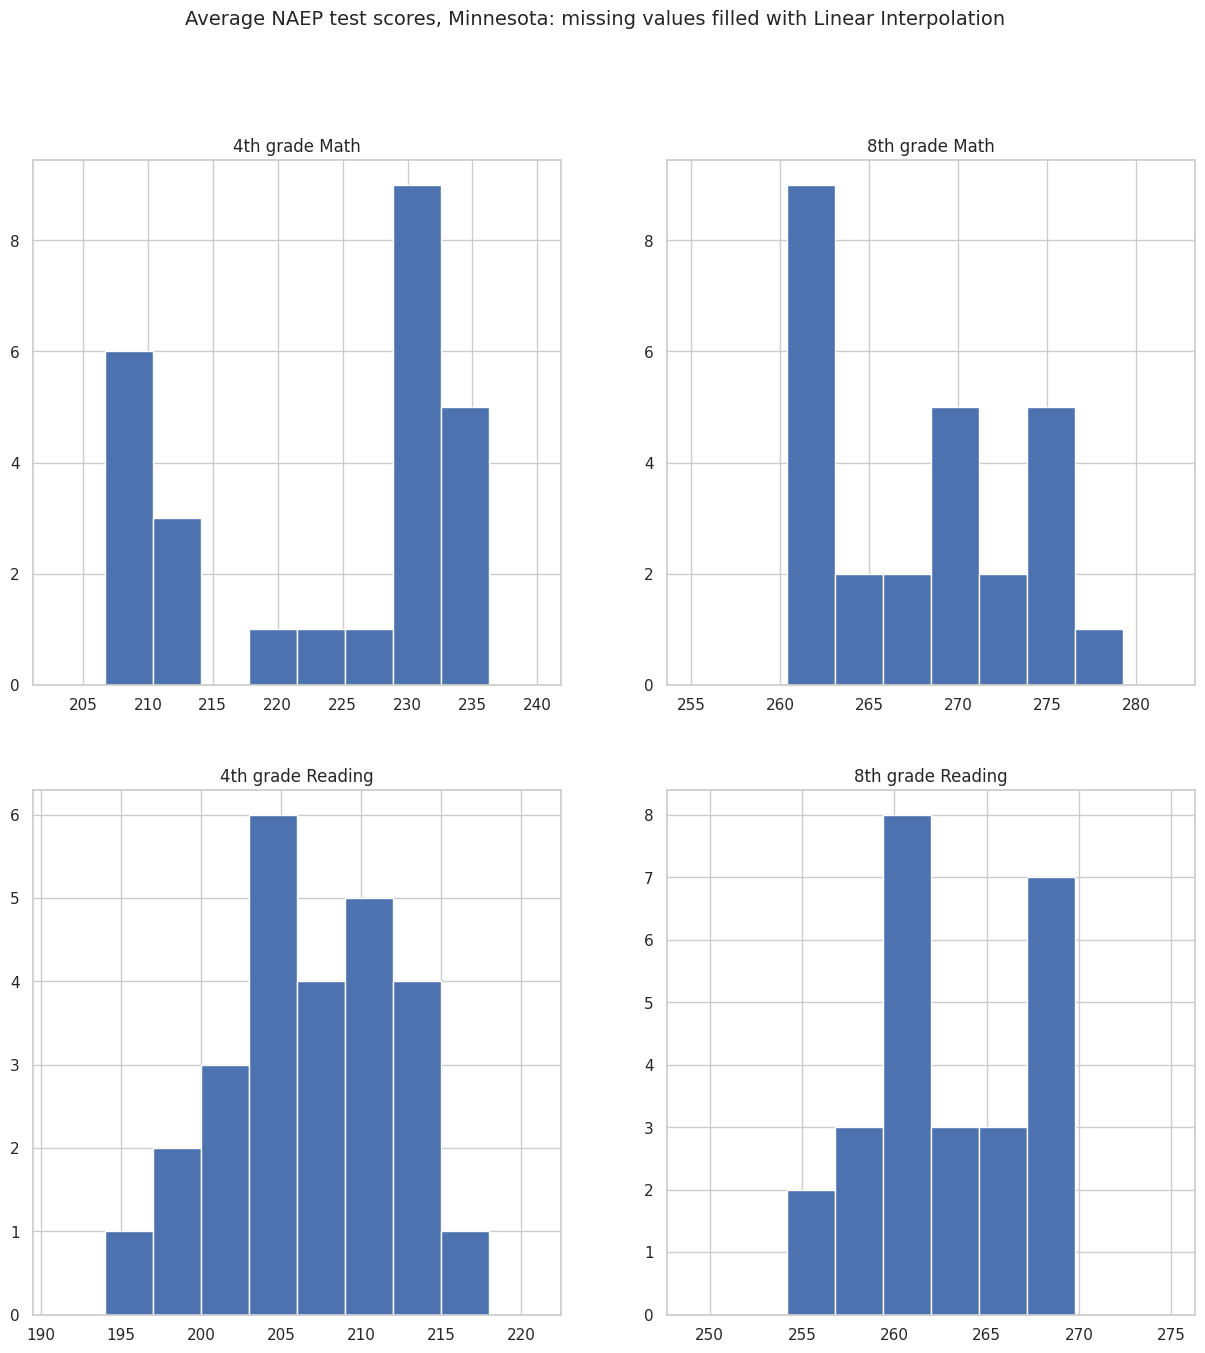

In [46]:
plot_naep(education_df_interp,test_ranges,"missing values filled with Linear Interpolation")

The linear intrpolation method produces the best graphs (which reasonably resemble a normal distribution). However, the 8th grade math interpolated a large amount of missing values leading to a right-skewed distribution.